# Confocal_FISH__Wiener_SFC_noisy
Use the noisy image to determine the optimal window size of a Wiener filter.

In [1]:
import time
from collections import namedtuple

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

import scipy.ndimage

try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker

#from ipywidgets import *
try:
    import cv2
except:
    !pip install cv2
    import cv2
    
#import kernels
try:
    from skimage import io as skimage_io
except:
    !pip install scikit-image
    from skimage import io as skimage_io

try:
    import information_theory as IT
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    import information_theory as IT

import utils

from self_fourier_shell_correlation import fsc_utils as fsc
from scipy.ndimage import map_coordinates # For interpolating the 1D filter to 2D

In [2]:
# apt install cm-super-minimal
# apt install dvipng
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica",
    "font.family": "Serif",
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amsfonts}"
})

In [3]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)

In [4]:
try:
    from scipy.signal import wiener
except:
    !pip install scipy
    from scipy.signal import wiener

In [5]:
Args = namedtuple("args", ["clean", "noisy"])
args = Args("http://www.hpca.ual.es/~vruiz/images/FDM/Confocal_FISH.png",
         "http://www.hpca.ual.es/~vruiz/images/FDM/Confocal_FISH_1.png")

In [6]:
Y = skimage_io.imread(args.noisy)

In [7]:
X = skimage_io.imread(args.clean)

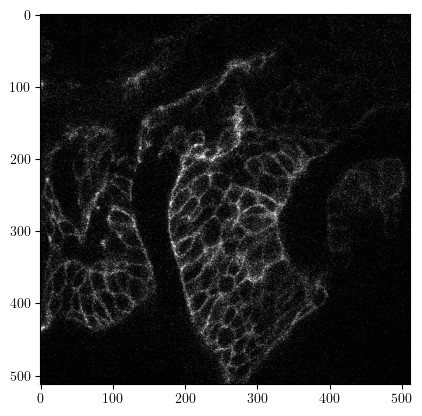

In [8]:
plt.imshow(Y, cmap="gray")

In [9]:
freq, Y_SFC = fsc.get_SFRC_curve__even_odd(Y)

compute_fourier_shell_correlation.shape=(512, 256)
compute_fourier_shell_correlation.shape=(256, 512)


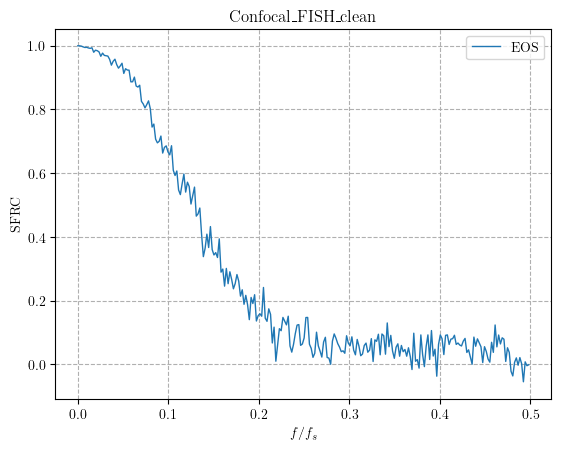

In [10]:
plt.plot(freq, Y_SFC, linewidth=1, label="EOS")
plt.grid(which="major", linestyle="--")
plt.xlabel(r"$f/f_s$")
plt.ylabel(r"\text{SFRC}")
plt.title(r"$\mathrm{Confocal\_FISH\_clean}$")
plt.legend()
#plt.savefig('Confocal_FISH_clean_SFRC.pdf', bbox_inches='tight')
plt.show()

In [11]:
# Compute FFT and shift the zero-frequency component to the center
FFT_Y = np.fft.fft2(Y)
shifted_FFT_Y = np.fft.fftshift(FFT_Y)

In [12]:
# Get dimensions of the FFT image
rows, cols = X.shape
center_row, center_col = rows // 2, cols // 2
print(center_row, center_col)

256 256


In [13]:
# Create coordinate matrices for all points in the 2D frequency space,
# with (0,0) at the center (due to fftshift).
# These coordinates range from -N to N-1 along each axis.
u = np.arange(cols) - center_col
v = np.arange(rows) - center_row
U, V = np.meshgrid(u, v)

In [14]:
# Calculate the radial distance from the center for each point (u, v) in the 2D grid.
# np.hypot(U, V) is equivalent to sqrt(U**2 + V**2)
radial_distances_2d = np.hypot(U, V)

In [15]:
# Map these 2D radial distances to the SFRC using interpolation.
# `map_coordinates` is used here to sample `Y_SFC' at the floating-point
# radial distances calculated for every coef in the 2D frequency plane.
# `order=1` means linear interpolation. `mode='nearest'` handles distances
# that fall outside the [0, N-1] range by taking the value of the nearest valid coefficient.
# This effectively extends the last SFC curve point's value for very high frequencies.
coords_for_interpolation = radial_distances_2d.flatten()
SFC_2D_Y = map_coordinates(Y_SFC, [coords_for_interpolation], order=1, mode='nearest').reshape(rows, cols)

In [16]:
# Create coordinate matrices for all points in the 2D frequency space,
# with (0,0) at the center (due to fftshift).
# These coordinates range from -N to N-1 along each axis.
u = np.arange(cols) - center_col
v = np.arange(rows) - center_row
U, V = np.meshgrid(u, v)

In [17]:
# --- Apply the filter (coefficient-wise multiplication) ---
# Multiply the shifted FFT image by the 2D version of the SFC curve.
# This attenuates high-frequency components.
filtered_FFT_Y = shifted_FFT_Y * SFC_2D_Y

In [18]:
# --- Perform Inverse FFT to get the filtered image ---
# First, inverse shift the filtered FFT to bring the zero-frequency back to the corner.
# Then, apply the inverse 2D FFT.
# `.real` is used because the original image was real, and `ifft2` can sometimes
# produce tiny imaginary components due to floating-point inaccuracies.
denoised_Y = np.fft.ifft2(np.fft.ifftshift(filtered_FFT_Y)).real

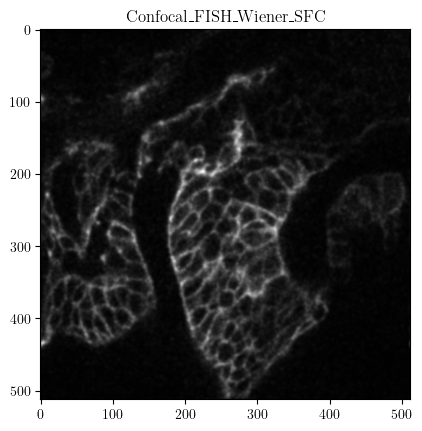

In [19]:
plt.title(r"$\mathrm{Confocal\_FISH\_Wiener\_SFC}$")
plt.imshow(denoised_Y, cmap="gray")
plt.savefig('Confocal_FISH_Wiener_SFC.pdf', bbox_inches='tight')

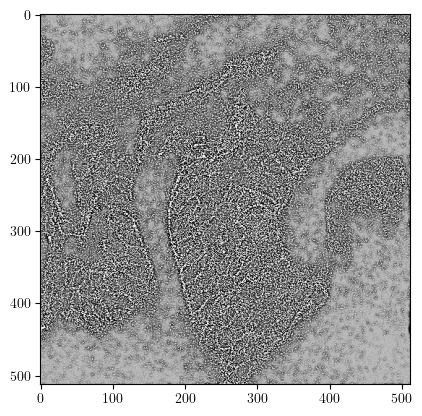

In [20]:
plt.imshow(cv2.equalizeHist(((Y-denoised_Y) + 128).astype(np.uint8)), cmap="gray")

In [21]:
PCC = np.corrcoef(denoised_Y.flatten(), X.flatten())[0, 1]
print(PCC)

0.954062369807471


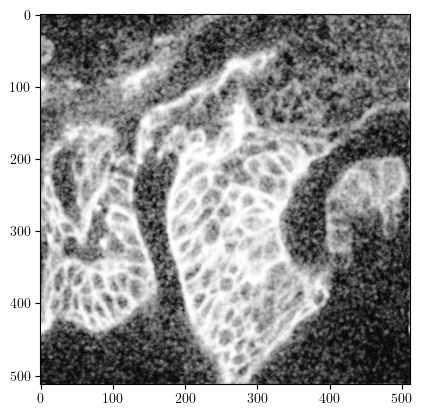

In [22]:
plt.imshow(cv2.equalizeHist(((denoised_Y)).astype(np.uint8)), cmap="gray")

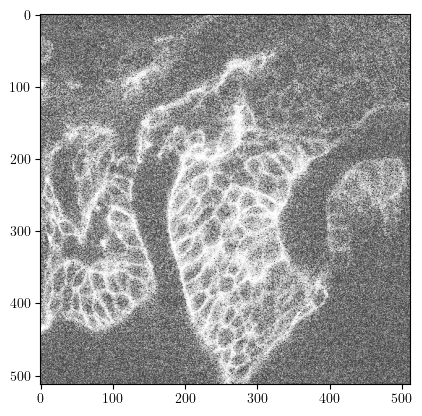

In [23]:
plt.imshow(cv2.equalizeHist(((Y)).astype(np.uint8)), cmap="gray")

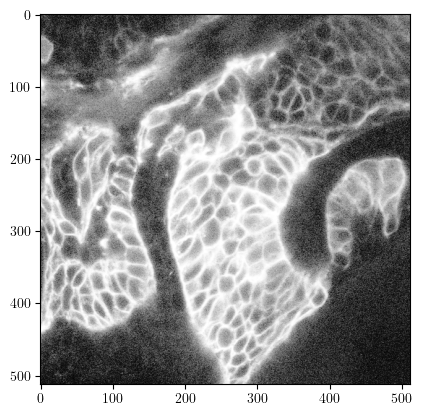

In [24]:
plt.imshow(cv2.equalizeHist(((X)).astype(np.uint8)), cmap="gray")